In [13]:
# This notebook creates the final noise tresholds 
# for use in Spark streaming.
import glob
import pandas
import numpy as np
raw_filenames = sorted(glob.glob('data/#2_87_noise_segments/*.csv'))
def find_index_of_list_containing_string(l, s):
    for e in l:
        if s in e:
            return l.index(e)
file_to_import = raw_filenames[find_index_of_list_containing_string(raw_filenames, "part")]    
# Load the 61 column file
raw_file = pandas.read_csv(file_to_import, header=None)

In [23]:
raw_filenames

['data/#2_87_noise_segments/average_PSD.csv',
 'data/#2_87_noise_segments/part-00000-5e013f34-898b-4ec8-98ee-b3b56c6d6964-c000.csv']

In [15]:
print("Minutes of extracted noise: " + str(raw_file.count()[0]/(10000*60)))

Minutes of extracted noise: 3.68849


In [16]:
S = np.array(raw_file[0])
# Sampling
Fs = 10000 # [1/s] # 10 kHz
dt = 1/float(Fs) # [s]
L = len(S) # [#samples]

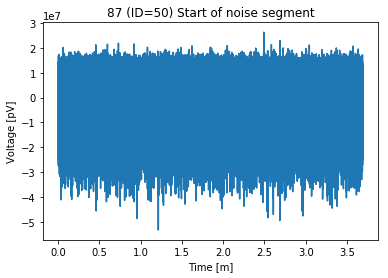

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
t = np.arange(0,L*dt/60,dt/60)
plt.figure(1)
plt.title("87 (ID=50) combined noise segments")
plt.xlabel("Time [m]")
plt.ylabel("Voltage [pV]")
plt.plot(t,S)

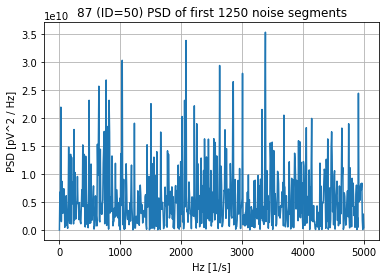

In [18]:
# Power spectral density of first 1250 segments
from scipy import signal
#f_fft_scipy, Sxx_fft_scipy = signal.periodogram(S, fs=Fs, scaling="density")
f_fft_scipy, Sxx_fft_scipy = signal.periodogram(S[0:1250], fs=Fs, scaling="density")
plt.figure(2)
plt.grid()
plt.title("87 (ID=50) PSD of first 1250 noise segments")
plt.xlabel("Hz [1/s]")
plt.ylabel("PSD [pV^2 / Hz]")
plt.plot(f_fft_scipy, Sxx_fft_scipy)

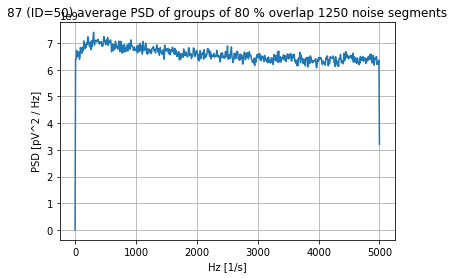

In [19]:
# Average PSD of all 80 % overlapping 1250 segments
total_samples_of_noise = len(S)
window_start_sample = 0
window_duration_samples = 1250
window_overlap = 0.8
window_offsets = np.arange(0, total_samples_of_noise - window_duration_samples, \
                           int(np.ceil(window_duration_samples*(1-window_overlap))))
# prepare PSD matrix
number_of_bins = f_fft_scipy.size # = f_fft_scipy.size = 626 with 8 Hz bin size
PSD_matrix = np.zeros((window_offsets.size, number_of_bins), dtype="float")
# calculate all the PSDs
for index, current_window_offset in enumerate(window_offsets):
    current_window_start_sample = window_start_sample + current_window_offset
    current_window_end_sample = window_duration_samples + current_window_offset
    f_fft_scipy, Sxx_fft_scipy = signal.periodogram(S[current_window_start_sample:current_window_end_sample], fs=Fs, scaling="density")
    PSD_matrix[index] = Sxx_fft_scipy
# calculate the average PSD
Sxx_average = np.array([np.mean(freq_bin) for freq_bin in PSD_matrix.T])
# plot the average PSD
plt.figure(3)
plt.grid()
plt.title("87 (ID=50) average PSD of groups of 80 % overlap 1250 noise segments")
plt.xlabel("Hz [1/s]")
plt.ylabel("PSD [pV^2 / Hz]")
plt.plot(f_fft_scipy, Sxx_average)

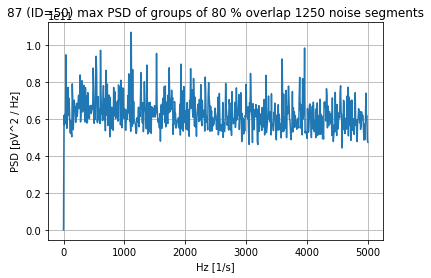

In [20]:
# calculate the max PSD
Sxx_max = np.array([np.max(freq_bin) for freq_bin in PSD_matrix.T])
# plot the average PSD
plt.figure(4)
plt.grid()
plt.title("87 (ID=50) max PSD of groups of 80 % overlap 1250 noise segments")
plt.xlabel("Hz [1/s]")
plt.ylabel("PSD [pV^2 / Hz]")
plt.plot(f_fft_scipy, Sxx_max)

In [22]:
#def make_unscrambler_friendly_list(numpy_array_or_list):
#    # converts number into string and replaces . comma with , comma
#    return [ str(number).replace('.',',') for number in numpy_array_or_list ]

# save the average PSD to a file, for use as tresholds on the spark streaming application
#np.savetxt("data/#2_87_noise_segments/max_PSD.csv", Sxx_max)